In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL

In [2]:
args = {}
args['dim_h'] = 40            # factor controlling size of hidden layers
args['n_channel'] = 1         # number of channels in the input data (MNIST is 1, aka greyscale)
args['n_z'] = 20              # number of dimensions in latent space. 
args['sigma'] = 1.0           # variance in n_z
args['lambda'] = 0.01         # hyper param for weight of discriminator loss
args['lr'] = 0.0002           # learning rate for Adam optimizer
args['epochs'] = 50           # how many epochs to run for
args['batch_size'] = 256      # batch size for SGD
args['save'] = False          # save weights at each epoch of training if True
args['train'] = False         # train networks if True, else load networks from saved weights
args['dataset'] = 'mnist'     # specify which dataset to use

In [3]:
# general purpose functions -- abstract to library
def interpolate(z1, z2,steps=10):
    z_int = torch.zeros([steps, z1.shape[0]])
    
    for i in range(z1.shape[0]):
        start = z1[i].data.item()
        end = z2[i].data.item()
        z_int[:,i] = torch.linspace(start,end, steps=steps)
    
    return z_int

def plot_row(images, size=(80,100)):
    images = images.detach().numpy()
    x = images.shape[0]
    fig = plt.figure(figsize=size)

    for i in range(x):
        a = fig.add_subplot(1,x,i+1)
        a.imshow(images[i,0], cmap='gray' )
        a.axis('off')
        a.set_aspect('equal')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    plt.close()

In [49]:
torch.manual_seed(101)

## load Dataset
if args['dataset'] == 'mnist':
    trainset = datasets.MNIST(
        root='./MNIST/',
        train=True,
        transform=transforms.ToTensor(),
        download=True
    )

    testset = datasets.MNIST(
        root='./MNIST/',
        train=False,
        transform=transforms.ToTensor(),
        download=True
    )
elif args['dataset'] == 'fmnist':
    trainset = datasets.FashionMNIST(
        root='./FMNIST/',
        train=True,
        transform=transforms.ToTensor(),
        download=True
    )

    testset = datasets.FashionMNIST(
        root='./FMNIST/',
        train=False,
        transform=transforms.ToTensor(),
        download=True
    )
    
train_loader = DataLoader(
    dataset=trainset,
    batch_size=args['batch_size'],
    shuffle=True
)


test_loader = DataLoader(
    dataset=testset,
    batch_size=args['batch_size'],
    shuffle=False
)

In [50]:
# load some images
for images, labels in test_loader:
        break

## Try out the vanilla autoencoder 

In [43]:
## create encoder model and decoder model
class AE_Encoder(nn.Module):
    def __init__(self, args):
        super(AE_Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters organized according to the popular DCGAN (Radford et. al., 2015) framework, excellent for image data
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 8),
            nn.ReLU(True),
        )
        
        # final layer is fully connected
        self.fc = nn.Linear(self.dim_h * (2 ** 3), self.n_z)

    def forward(self, x):
        x = self.conv(x)
        x = x.squeeze()
        x = self.fc(x)
        return x

class AE_Decoder(nn.Module):
    def __init__(self, args):
        super(AE_Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 7 * 7),
            nn.ReLU()
        )

        # deconvolutional filters, essentially the inverse of convolutional filters
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 8, 7, 7)
        x = self.deconv(x)
        return x

In [44]:
# instantiate models, and set to train mode
ae_encoder, ae_decoder = AE_Encoder(args), AE_Decoder(args)

if args['train']:
    # specify loss (mean squared error of image reconstruction)
    criterion = nn.MSELoss()

    # use the Adam optimizer, it's always a good choice
    enc_optim = torch.optim.Adam(ae_encoder.parameters(), lr = args['lr'])
    dec_optim = torch.optim.Adam(ae_decoder.parameters(), lr = args['lr'])

    enc_scheduler = torch.optim.lr_scheduler.StepLR(enc_optim, step_size=30, gamma=0.5)
    dec_scheduler = torch.optim.lr_scheduler.StepLR(dec_optim, step_size=30, gamma=0.5)

    for epoch in range(args['epochs']):
        for images, _ in tqdm(train_loader):
            ae_encoder.train()
            ae_decoder.train()

            ae_encoder.zero_grad()
            ae_decoder.zero_grad()
            batch_size = images.size()[0]

            z_hat = ae_encoder(images)
            x_hat = ae_decoder(z_hat)
            train_recon_loss = criterion(x_hat, images)

            train_recon_loss.backward()

            enc_optim.step()
            dec_optim.step()

        # Run validation set
        ae_encoder.eval()
        ae_decoder.eval()
        for images, _ in tqdm(test_loader):
            z_hat = ae_encoder(images)
            x_hat = ae_decoder(z_hat)
            test_recon_loss = criterion(x_hat, images)

        if args['save']:
            save_path = './save/AE_{}-epoch_{}.pth'
            torch.save(ae_encoder.state_dict(), save_path.format('encoder', epoch))
            torch.save(ae_decoder.state_dict(), save_path.format('decoder', epoch))

        print("Epoch: [{}/{}], \tTrain Reconstruction Loss: {}\n\t\t\tTest Reconstruction Loss: {}".format(
            epoch + 1, 
            args['epochs'], 
            train_recon_loss.data.item(),
            test_recon_loss.data.item()
        ))
else:
    # load encoder and decoder weights from checkpoint
    enc_checkpoint = torch.load('save/AE_encoder-best_{}.pth'.format(args['dataset']))
    ae_encoder.load_state_dict(enc_checkpoint)

    dec_checkpoint = torch.load('save/AE_decoder-best_{}.pth'.format(args['dataset']))
    ae_decoder.load_state_dict(dec_checkpoint)

## Let's look at some images

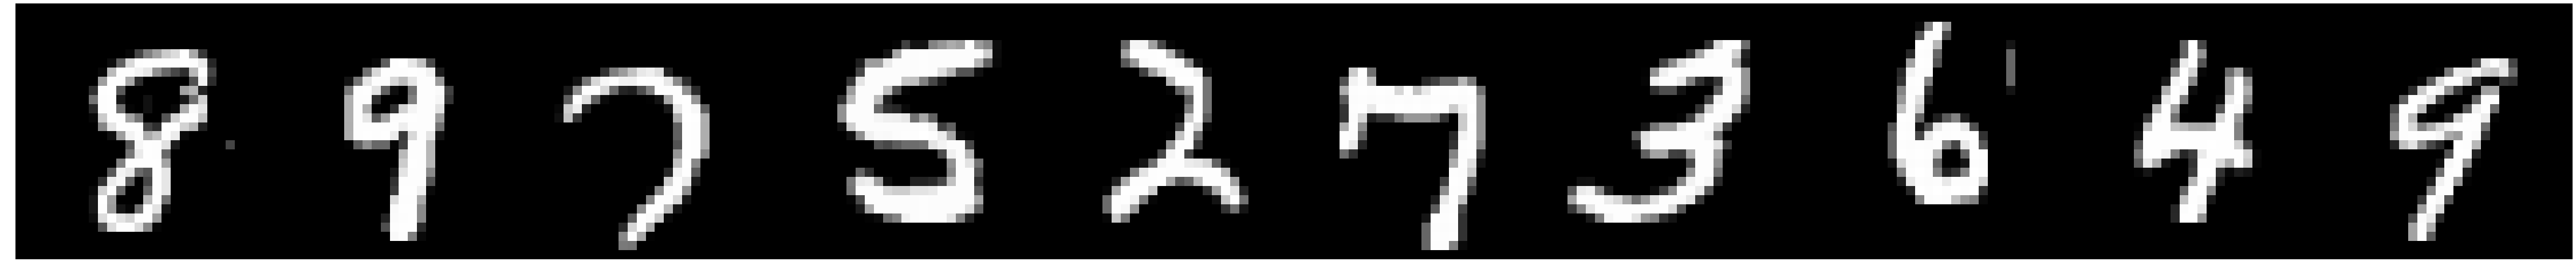

In [45]:
# look at an original images
plot_row(images[:10])

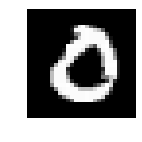

In [28]:
fig, ax = plt.subplots(figsize=(2,2))
images_test = images.detach().numpy()

plt.imshow(images_test[10][0], cmap="gray")
plt.axis("off")
ax.set_aspect("equal")
plt.savefig("./images/sample_pixel.png", bbox_inches = 'tight', pad_inches = 0)
plt.show()

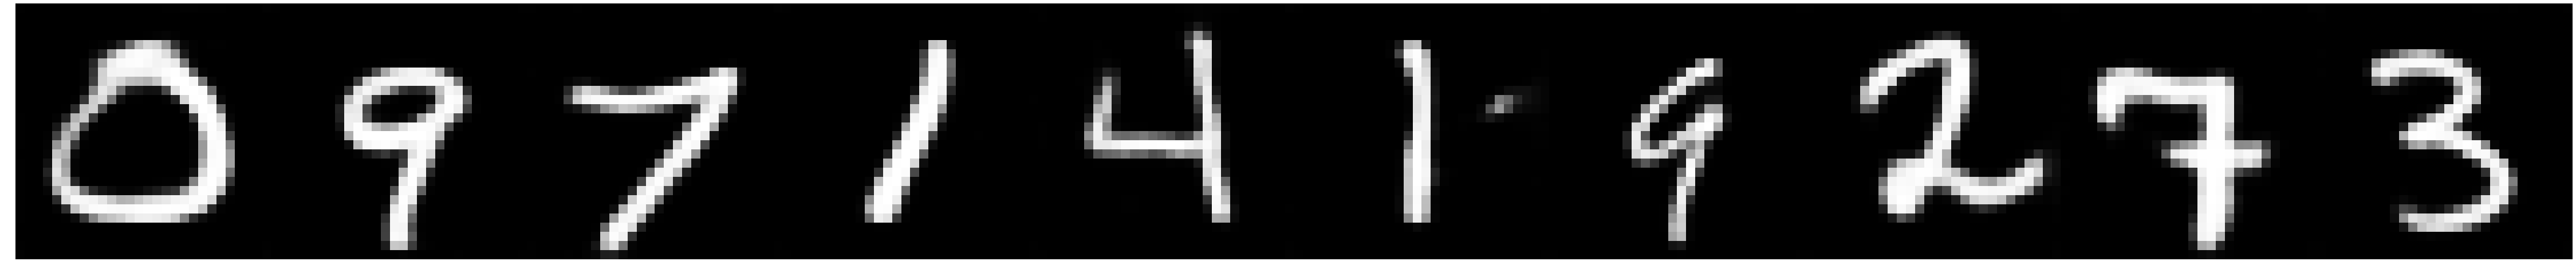

In [9]:
# run same image through autoencoder and take a peak
z_reps = ae_encoder(images)
decoded_images = ae_decoder(z_reps)

plot_row(decoded_images[:10])

In [10]:
z_reps.shape

torch.Size([256, 20])

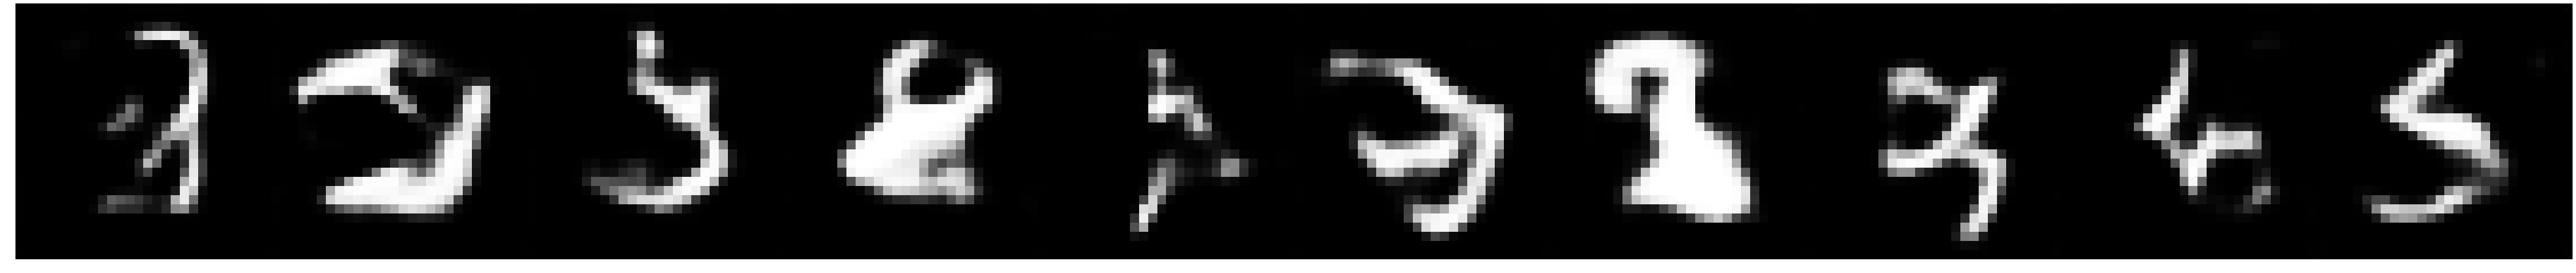

In [11]:
torch.manual_seed(100)
# try a random sample of the latent space
rand_z_reps = torch.randn_like(z_reps)
rand_decoded_images = ae_decoder(rand_z_reps)

plot_row(rand_decoded_images[:10])

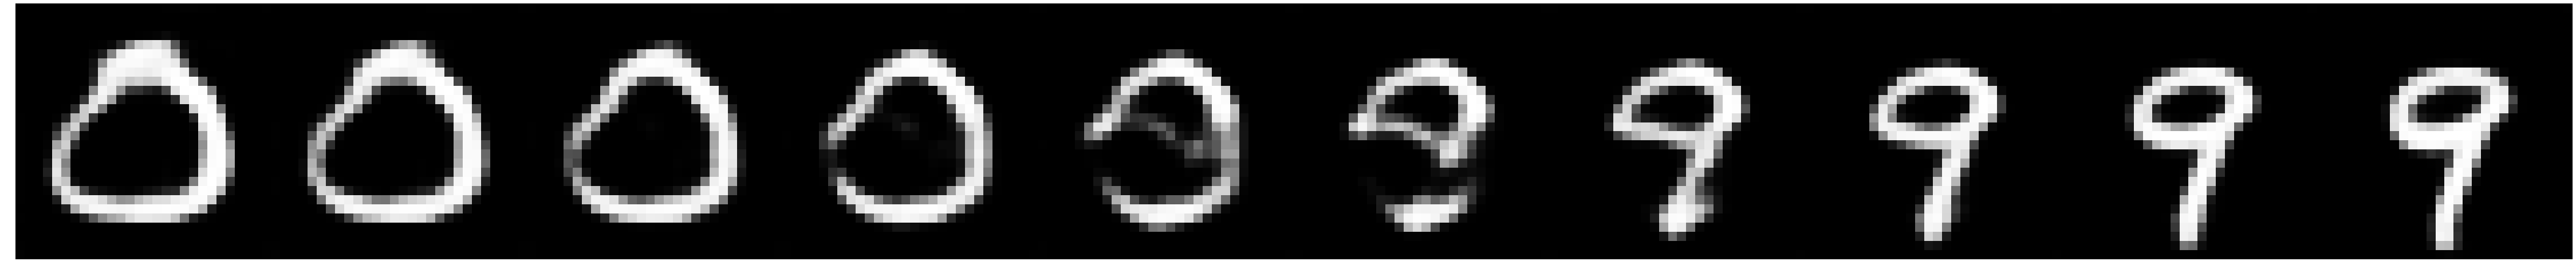

In [12]:
z_int = interpolate(z_reps[0],z_reps[1])

decoded_images = ae_decoder(z_int)
plot_row(decoded_images)

In [13]:
# plts = pd.DataFrame(z_reps.detach().numpy()).hist()


## VAE

In [9]:
## create encoder model and decoder model
class VAE_Encoder(nn.Module):
    def __init__(self, args):
        super(VAE_Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters, work excellent with image data
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 8),
            nn.ReLU(True),
        )
        
        # final layer is fully connected
        self.fc1 = nn.Linear(self.dim_h * (2 ** 3), self.n_z)
        self.fc2 = nn.Linear(self.dim_h * (2 ** 3), self.n_z)

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
        
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    
    def forward(self, x):
        h = self.conv(x)
        h = h.squeeze()
        z, mu, logvar = self.bottleneck(h)
        
        return z, mu, logvar

class VAE_Decoder(nn.Module):
    def __init__(self, args):
        super(VAE_Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 7 * 7),
            nn.ReLU()
        )

        # deconvolutional filters, essentially the inverse of convolutional filters
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 8, 7, 7)
        x = self.deconv(x)
        return x

In [10]:
# instantiate models, and set to train mode
vae_encoder, vae_decoder = VAE_Encoder(args), VAE_Decoder(args)

if args['train']:
    # specify loss (mean squared error of pixel by pixel image reconstruction)
    criterion = nn.MSELoss()

    # use the Adam optimizer, it's always a good choice
    enc_optim = torch.optim.Adam(vae_encoder.parameters(), lr = args['lr'])
    dec_optim = torch.optim.Adam(vae_decoder.parameters(), lr = args['lr'])

    enc_scheduler = torch.optim.lr_scheduler.StepLR(enc_optim, step_size=30, gamma=0.5)
    dec_scheduler = torch.optim.lr_scheduler.StepLR(dec_optim, step_size=30, gamma=0.5)

    for epoch in range(args['epochs']):
        for images, _ in tqdm(train_loader):
            vae_encoder.train()
            vae_decoder.train()

            vae_encoder.zero_grad()
            vae_decoder.zero_grad()
            batch_size = images.size()[0]

            z_hat, mu, logvar = vae_encoder(images)
            x_hat = vae_decoder(z_hat)
            
            BCE = nn.functional.binary_cross_entropy(
                x_hat.view(-1,784), 
                images.view(-1, 784), 
                reduce=False
            ).sum()
            
            KLD = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            
            ELBO = BCE - KLD
            ELBO.backward()
                        
            enc_optim.step()
            dec_optim.step()

        # Run validation set
        vae_encoder.eval()
        vae_decoder.eval()
        for images, _ in tqdm(test_loader):
            z_hat, mu, logvar = vae_encoder(images)
            x_hat = vae_decoder(z_hat)
            test_recon_loss = criterion(x_hat, images) # maybe change to BCE?

        if args['save']:
            save_path = './save/VAE_{}-epoch_{}.pth'
            torch.save(vae_encoder.state_dict(), save_path.format('encoder', epoch))
            torch.save(vae_decoder.state_dict(), save_path.format('decoder', epoch))

        print("Epoch: [{}/{}], \tTrain Reconstruction Loss: {} \tKLD:{}\n\t\t\tTest Reconstruction Loss: {}".format(
            epoch + 1, 
            args['epochs'], 
            BCE.data.item(),
            KLD.data.item(),
            test_recon_loss.data.item()
        ))
else:
    # load encoder and decoder weights from checkpoint
    enc_checkpoint = torch.load('save/VAE_encoder-best_{}.pth'.format(args['dataset']))
    vae_encoder.load_state_dict(enc_checkpoint)

    dec_checkpoint = torch.load('save/VAE_decoder-best_{}.pth'.format(args['dataset']))
    vae_decoder.load_state_dict(dec_checkpoint)

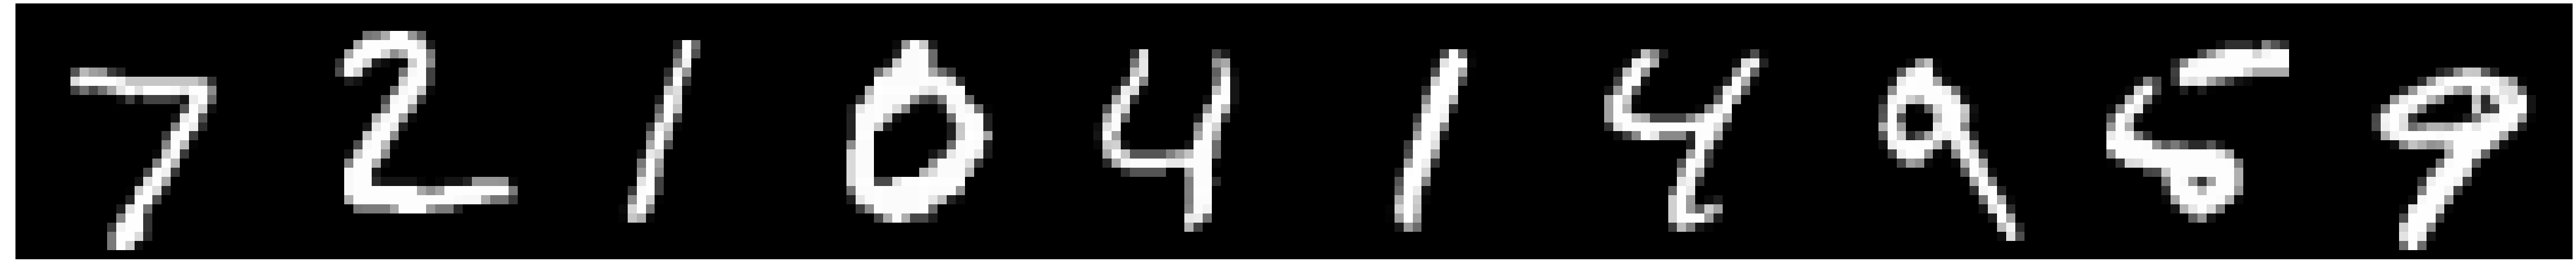

In [51]:
# look at an original images
plot_row(images[:10])

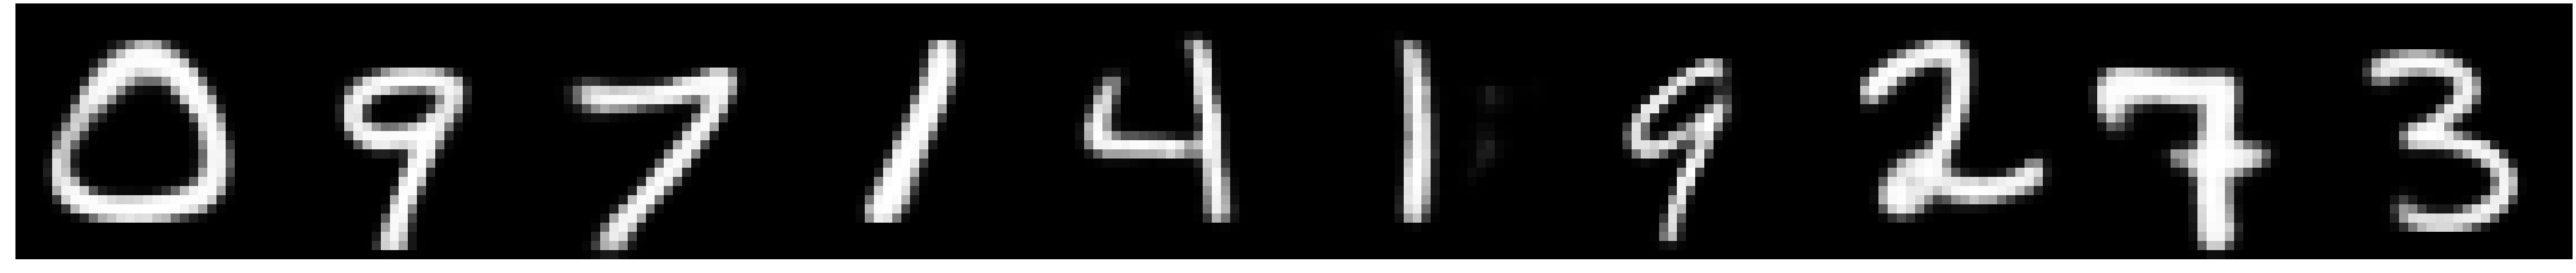

In [17]:
# run same image through autoencoder and take a peak
z_reps = vae_encoder(images)
decoded_images = vae_decoder(z_reps[0])

plot_row(decoded_images[:10])

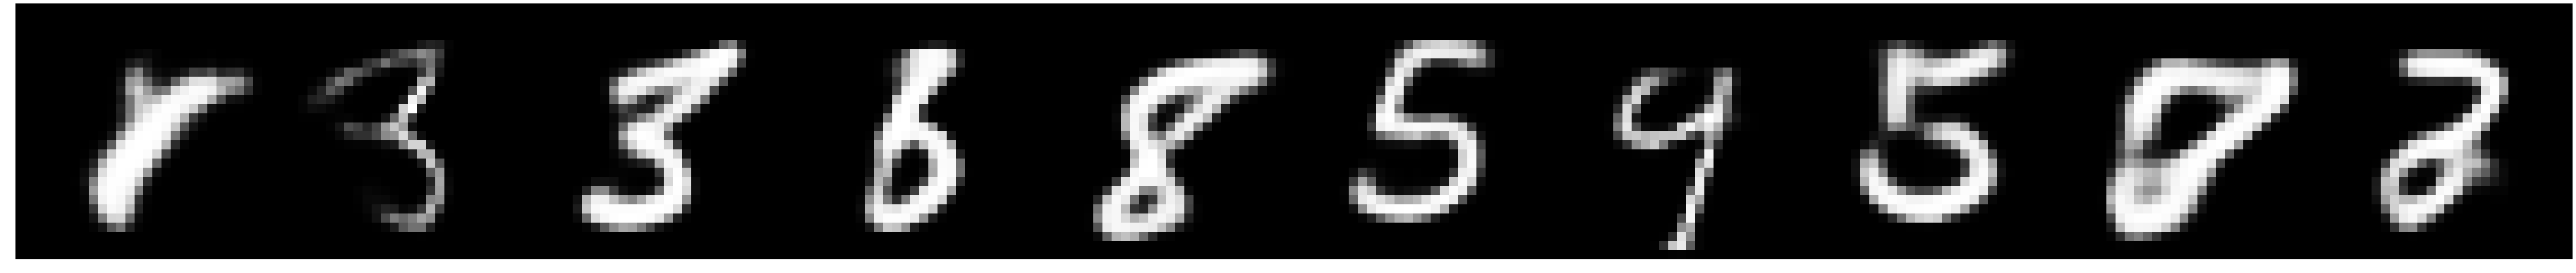

In [18]:
torch.manual_seed(100)
# try a random sample of the latent space
rand_z_reps = torch.randn_like(z_reps[0])
rand_decoded_images = vae_decoder(rand_z_reps)

plot_row(rand_decoded_images[:10])

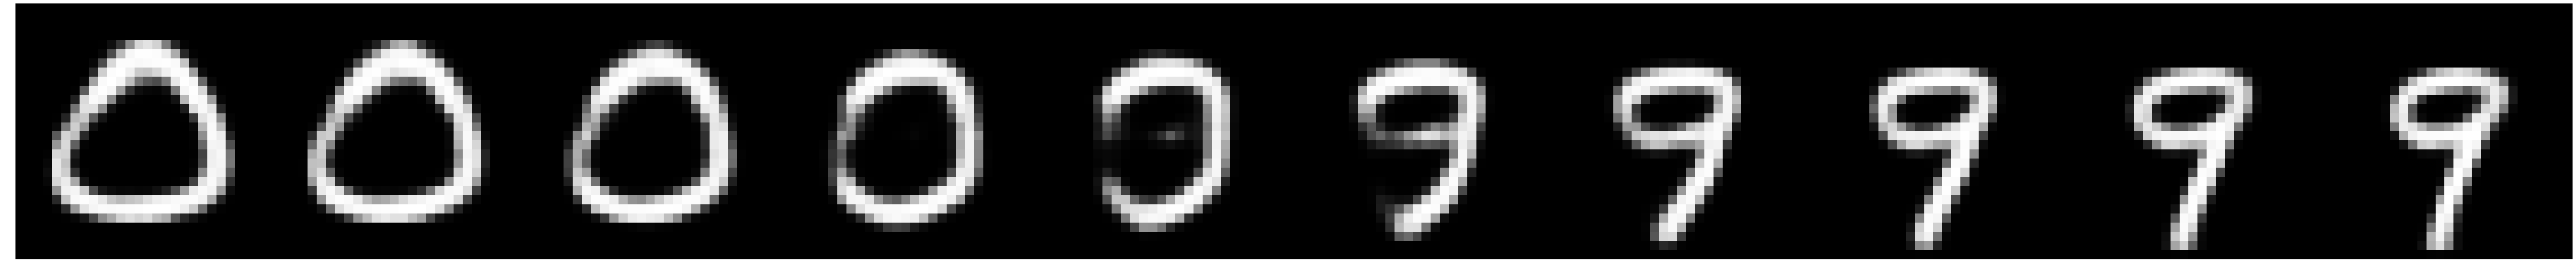

In [19]:
z_int = interpolate(z_reps[0][0],z_reps[0][1])

decoded_images = vae_decoder(z_int)
plot_row(decoded_images)

In [20]:
# plts = pd.DataFrame(z_reps.detach().numpy()).hist()

## WAE-GAN

In [11]:
## create encoder model and decoder model
class WAE_Encoder(nn.Module):
    def __init__(self, args):
        super(WAE_Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters, work excellent with image data
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 8),
            nn.ReLU(True),
        )
        
        # final layer is fully connected
        self.fc = nn.Linear(self.dim_h * (2 ** 3), self.n_z)

    def forward(self, x):
        x = self.conv(x)
        x = x.squeeze()
        x = self.fc(x)
        return x

class WAE_Decoder(nn.Module):
    def __init__(self, args):
        super(WAE_Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 7 * 7),
            nn.ReLU()
        )

        # deconvolutional filters, essentially the inverse of convolutional filters
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 8, 7, 7)
        x = self.deconv(x)
        return x

# define the descriminator
class Discriminator(nn.Module):
    def __init__(self, args):
        super(Discriminator, self).__init__()

        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # main body of discriminator, returns [0,1]
        self.main = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        return x
    
# control which parameters are frozen / free for optimization
def free_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def frozen_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False

In [12]:
# instantiate discriminator model, and restart encoder and decoder, for fairness. Set to train mode, etc
wae_encoder, wae_decoder, discriminator = WAE_Encoder(args), WAE_Decoder(args), Discriminator(args)

criterion = nn.MSELoss()

if args['train']:
    enc_optim = torch.optim.Adam(wae_encoder.parameters(), lr = args['lr'])
    dec_optim = torch.optim.Adam(wae_decoder.parameters(), lr = args['lr'])
    dis_optim = torch.optim.Adam(discriminator.parameters(), lr = args['lr'])

    enc_scheduler = torch.optim.lr_scheduler.StepLR(enc_optim, step_size=30, gamma=0.5)
    dec_scheduler = torch.optim.lr_scheduler.StepLR(dec_optim, step_size=30, gamma=0.5)
    dis_scheduler = torch.optim.lr_scheduler.StepLR(dis_optim, step_size=30, gamma=0.5)

    # one and -one allow us to control descending / ascending gradient descent
    one = torch.Tensor([1])
    
    for epoch in range(args['epochs']):

        # train for one epoch -- set nets to train mode
        wae_encoder.train()
        wae_decoder.train()
        discriminator.train()

        for images, _ in tqdm(train_loader):
            # zero gradients for each batch
            wae_encoder.zero_grad()
            wae_decoder.zero_grad()
            discriminator.zero_grad()

            # ======== Train Discriminator ======== #

            # freeze auto encoder params
            frozen_params(wae_decoder)
            frozen_params(wae_encoder)

            # free discriminator params
            free_params(discriminator)

            # run discriminator against randn draws
            z = torch.randn(images.size()[0], args['n_z']) * args['sigma']
            d_z = discriminator(z)

            # run discriminator against encoder z's
            z_hat = wae_encoder(images)
            d_z_hat = discriminator(z_hat)

            d_z_loss = args['lambda']*torch.log(d_z).mean()
            d_z_hat_loss = args['lambda']*torch.log(1 - d_z_hat).mean()

            # formula for ascending the descriminator -- -one reverses the direction of the gradient.
            d_z_loss.backward(-one)
            d_z_hat_loss.backward(-one)

            dis_optim.step()

            # ======== Train Generator ======== #

            # flip which networks are frozen, which are not
            free_params(wae_decoder)
            free_params(wae_encoder)
            frozen_params(discriminator)

            batch_size = images.size()[0]

            # run images
            z_hat = wae_encoder(images)
            x_hat = wae_decoder(z_hat)

            # discriminate latents
            z_hat2 = wae_encoder(Variable(images.data))
            d_z_hat = discriminator(z_hat2)

            # calculate reconstruction loss
            # WAE is happy with whatever cost function, let's use BCE
            BCE = nn.functional.binary_cross_entropy(
                x_hat.view(-1,784), 
                images.view(-1, 784), 
                reduce=False
            ).mean()
            
            # calculate discriminator loss
            d_loss = args['lambda'] * (torch.log(d_z_hat)).mean()
            
            # we keep the BCE and d_loss on separate graphs to increase efficiency in pytorch
            BCE.backward(one)
            # -one reverse the direction of the gradient, minimizing BCE - d_loss
            d_loss.backward(-one)

            enc_optim.step()
            dec_optim.step()

        # test on test set
        wae_encoder.eval()
        wae_decoder.eval()
        for images, _ in tqdm(test_loader):
            z_hat = wae_encoder(images)
            x_hat = wae_decoder(z_hat)
            test_recon_loss = criterion(x_hat, images)

        
        if args['save']:
            save_path = './save/WAEgan_{}-epoch_{}.pth'
            torch.save(wae_encoder.state_dict(), save_path.format('encoder', epoch))
            torch.save(wae_decoder.state_dict(), save_path.format('decoder', epoch))
            torch.save(discriminator.state_dict(), save_path.format('discriminator', epoch))

        # print stats after each epoch
        print("Epoch: [{}/{}], \tTrain Reconstruction Loss: {} d loss: {}, \n\t\t\tTest Reconstruction Loss:{}".format(
            epoch + 1, 
            args['epochs'], 
            BCE.data.item(),
            d_loss.data.item(),
            test_recon_loss.data.item()
        ))
        
else:
    enc_checkpoint = torch.load('save/WAEgan_encoder-best_{}.pth'.format(args['dataset']))
    wae_encoder.load_state_dict(enc_checkpoint)

    dec_checkpoint = torch.load('save/WAEgan_decoder-best_{}.pth'.format(args['dataset']))
    wae_decoder.load_state_dict(dec_checkpoint)
    
    dec_checkpoint = torch.load('save/WAEgan_discriminator-best_{}.pth'.format(args['dataset']))
    discriminator.load_state_dict(dec_checkpoint)

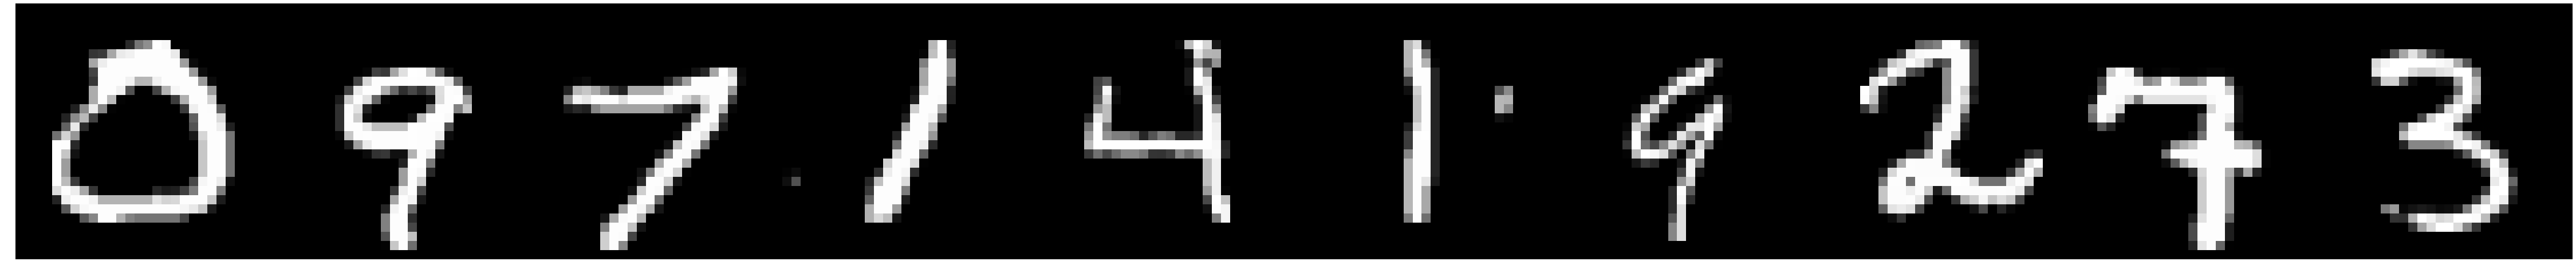

In [23]:
# look at an original images
plot_row(images[:10])

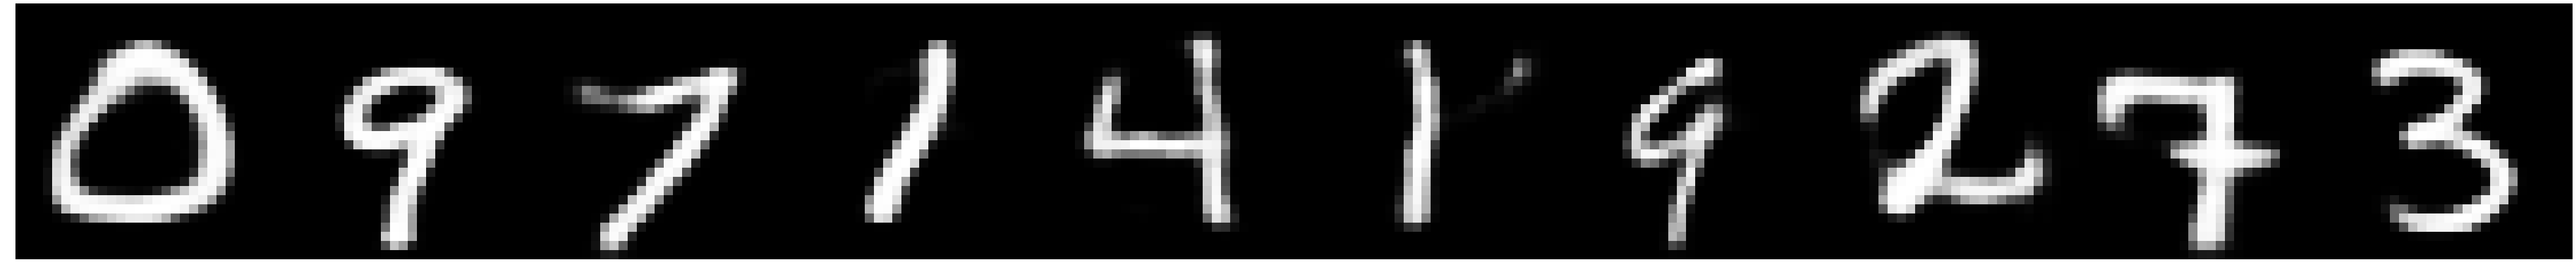

In [24]:
# run same image through autoencoder and take a peak
z_reps = wae_encoder(images)
decoded_images = wae_decoder(z_reps)

plot_row(decoded_images[:10])

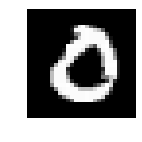

In [37]:
fig, ax = plt.subplots(figsize=(2,2))
images_test = images.detach().numpy()

plt.imshow(images_test[10][0], cmap="gray")
plt.axis("off")
ax.set_aspect("equal")
plt.savefig("./images/sample_pixel.png", bbox_inches = 'tight', pad_inches = 0)
plt.show()

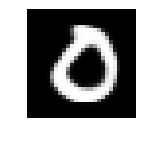

In [38]:
z_reps = ae_encoder(images)
decoded_images = ae_decoder(z_reps)

fig, ax = plt.subplots(figsize=(2,2))

plt.imshow(decoded_images[10][0].detach().numpy(), cmap="gray")
plt.axis("off")
ax.set_aspect("equal")
plt.savefig("./images/sample_ae.png", bbox_inches = 'tight', pad_inches = 0)
plt.show()

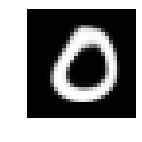

In [36]:
z_reps = vae_encoder(images)
decoded_images = vae_decoder(z_reps[0])

fig, ax = plt.subplots(figsize=(2,2))

plt.imshow(decoded_images[10][0].detach().numpy(), cmap="gray")
plt.axis("off")
ax.set_aspect("equal")
plt.savefig("./images/sample_vae.png", bbox_inches = 'tight', pad_inches = 0)
plt.show()

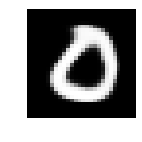

In [42]:
z_reps = wae_encoder(images)
decoded_images = wae_decoder(z_reps)

fig, ax = plt.subplots(figsize=(2,2))

plt.imshow(decoded_images[10][0].detach().numpy(), cmap="gray")
plt.axis("off")
ax.set_aspect("equal")
plt.savefig("./images/sample_wae.png", bbox_inches = 'tight', pad_inches = 0)
plt.show()

# Plotting Functions

In [13]:
def interpolate(z1, z2, steps=10):
    z_int = torch.zeros([steps, z1.shape[0]])
    
    for i in range(z1.shape[0]):
        start = z1[i].data.item()
        end = z2[i].data.item()
        z_int[:,i] = torch.linspace(start,end, steps=steps)
    
    return z_int

In [14]:
def plot_rows(images, save=False, filename="./images/reconstructions.png", 
              width=16, height=6.55, args=args, optimizer_name="Adam", 
              encoders = [ae_encoder, vae_encoder, wae_encoder], 
              decoders = [ae_decoder, vae_decoder, wae_decoder], 
              seed=100, padding=True):
    
    torch.manual_seed(seed)
    
    plot_images = []
    
    plot_images.append(images[:10].detach().numpy())

    for i, _ in enumerate(encoders):
        if i == 1:
            z_reps = encoders[i](images)
            plot_images.append(decoders[i](z_reps[0])[:10].detach().numpy())
        else:
            z_reps = encoders[i](images)
            plot_images.append(decoders[i](z_reps)[:10].detach().numpy())

    fig, axes = plt.subplots(4, 10, figsize=(width, height))

    for row, ax in enumerate(axes):
        for i, img in enumerate(ax): 
            ax[i].imshow(plot_images[row][i,0], cmap='gray' )
            ax[i].axis('off')
            ax[i].set_aspect('equal')

    plt.suptitle("Original images (row 1) compared to reconstructions "\
                 "for our AE (row 2), VAE (row 3), and WAE (row 4) implementations", y=0.92, fontsize=14)

    # add footnote with relevant model parameters
    figtext_text = "Parameters used: latent dimension size ({0}), hidden layer size ({1}), "\
                "epochs ({2}), batch size ({3}), optimizer ({4}), \n learning rate ({5}), "\
                "WAE sigma ({6}), WAE discriminator loss lambda weight ({7})".format(args["n_z"], 
                                                                                     args["dim_h"], 
                                                                                     args["epochs"],
                                                                                     args["batch_size"], 
                                                                                     optimizer_name, 
                                                                                     args["lr"], 
                                                                                     args["sigma"], 
                                                                                     args["lambda"])

    plt.figtext(.5, 0.12, figtext_text, fontsize=14, va="top", ha="center")

    plt.subplots_adjust(wspace=0, hspace=0)
    
    if save:
        if padding:
            plt.savefig(filename)
        else:
            plt.savefig(filename, bbox_inches = 'tight', pad_inches = 0)

    plt.show()

In [15]:
def plot_interpolation(images, start_idx=0, end_idx=1, save=False, show=True,
                       filename="./images/interpolations.png", titles=True,
                       width=16, height=6.55, args=args, optimizer_name="Adam", 
                       encoders = [ae_encoder, vae_encoder, wae_encoder], 
                       decoders = [ae_decoder, vae_decoder, wae_decoder], 
                       seed=100, padding=True):  
    
    torch.manual_seed(seed)

    interp_steps = 9

    plot_images = []
    
    start_pix = images[start_idx,0].numpy().copy()
    end_pix = images[end_idx,0].numpy().copy()
    diff = end_pix - start_pix
    lin_step_size = diff/interp_steps
    
    for i, _ in enumerate(encoders):
        if i == 1:
            z_reps = encoders[i](images)
            z_int = interpolate(z_reps[0][start_idx],z_reps[0][end_idx])
            plot_images.append(decoders[i](z_int).detach().numpy())
        else:
            z_reps = encoders[i](images)
            z_int = interpolate(z_reps[start_idx],z_reps[end_idx])
            plot_images.append(decoders[i](z_int).detach().numpy())

    fig, axes = plt.subplots(4, 10, figsize=(width, height))

    for i, img in enumerate(axes[0]):
            axes[0][i].imshow(start_pix, cmap='gray')
            axes[0][i].axis("off")
            axes[0][i].set_aspect('equal')
            start_pix += lin_step_size
    for row, ax in enumerate(axes[1:]):
        for i, img in enumerate(ax): 
            ax[i].imshow(plot_images[row][i,0], cmap='gray' )
            ax[i].axis('off')
            ax[i].set_aspect('equal')

    if titles:
        plt.suptitle("Linear interpolation in pixel space (row 1) compared to latent spaces "\
                     "for our AE (row 2), VAE (row 3), and WAE (row 4)", y=0.92, fontsize=14)

    # add footnote with relevant model parameters
        figtext_text = "Parameters used: latent dimension size ({0}), hidden layer size ({1}), "\
                    "epochs ({2}), batch size ({3}), optimizer ({4}), \n learning rate ({5}), "\
                    "WAE sigma ({6}), WAE discriminator loss lambda weight ({7})".format(args["n_z"], 
                                                                                         args["dim_h"], 
                                                                                         args["epochs"],
                                                                                         args["batch_size"], 
                                                                                         optimizer_name, 
                                                                                         args["lr"], 
                                                                                         args["sigma"], 
                                                                                         args["lambda"])

        plt.figtext(.5, 0.12, figtext_text, fontsize=14, va="top", ha="center")

    plt.subplots_adjust(wspace=0, hspace=0)
    
    if save:
        if padding:
            plt.savefig(filename)
        else:
            plt.savefig(filename, bbox_inches = 'tight', pad_inches = 0)
    
    if show:
        plt.show()
    else:
        plt.close(fig)

In [16]:
def plot_grid_interpolation(images, save=False, temp_path="./images/interpolations/", 
                            filename="./images/grid_interpolations.png", 
                            width=16, height=7, args=args, optimizer_name="Adam", 
                            seed=100, padding=True):
    imgs_list = []
    
    for i in range(9):
        img_filename = "{0}interpolations_{1}.png".format(temp_path, i)
        plot_interpolation(images, start_idx=i, end_idx=i+1, show=False,
                           titles=False, save=True, filename=img_filename, 
                           seed=seed, padding=False)
        imgs_list.append(img_filename)
    
    imgs = [ PIL.Image.open(i) for i in imgs_list ]

    imgs_row_0 = np.hstack((np.asarray(i) for i in imgs[:3]))
    imgs_row_1 = np.hstack((np.asarray(i) for i in imgs[3:6]))
    imgs_row_2 = np.hstack((np.asarray(i) for i in imgs[6:]))
    imgs_combined = np.vstack((imgs_row_0, imgs_row_1, imgs_row_2))

    fig = plt.subplots(figsize=(width, height))

    plt.imshow(imgs_combined)
    plt.axis("off")

    plt.suptitle("    Linear interpolation in pixel space (row 1 each example) and latent spaces "\
                 "for our AE (row 2), VAE (row 3), and WAE (row 4)", y=0.92, fontsize=14)

    # add footnote with relevant model parameters
    figtext_text = "Parameters used: latent dimension size ({0}), hidden layer size ({1}), "\
                "epochs ({2}), batch size ({3}), optimizer ({4}), \n learning rate ({5}), "\
                "WAE sigma ({6}), WAE discriminator loss lambda weight ({7})".format(args["n_z"], 
                                                                                     args["dim_h"], 
                                                                                     args["epochs"],
                                                                                     args["batch_size"], 
                                                                                     optimizer_name, 
                                                                                     args["lr"], 
                                                                                     args["sigma"], 
                                                                                     args["lambda"])

    plt.figtext(.5, 0.12, figtext_text, fontsize=14, va="top", ha="center")

    plt.subplots_adjust(wspace=0, hspace=0)
    
    if save:
        if padding:
            plt.savefig(filename)
        else:
            plt.savefig(filename, bbox_inches = 'tight', pad_inches = 0)    

    plt.show()

In [17]:
def plot_random(images, save=False, 
                filename="./images/random.png", 
                width=16, height=6.55, args=args, optimizer_name="Adam", 
                encoders = [ae_encoder, vae_encoder, wae_encoder], 
                decoders = [ae_decoder, vae_decoder, wae_decoder], 
                seed=100, padding=True):
    
    
    torch.manual_seed(seed)
    
    plot_images = []
    
    plot_images.append(torch.randn_like(images).detach().numpy())

    for i, _ in enumerate(encoders):
        if i == 1:
            z_reps = encoders[i](images)
            rand_z_reps = torch.randn_like(z_reps[0])
            plot_images.append(decoders[i](rand_z_reps).detach().numpy())
        else:
            z_reps = encoders[i](images)
            rand_z_reps = torch.randn_like(z_reps)
            plot_images.append(decoders[i](rand_z_reps).detach().numpy())

    fig, axes = plt.subplots(4, 10, figsize=(width, height))

    for row, ax in enumerate(axes):
        for i, img in enumerate(ax): 
            ax[i].imshow(plot_images[row][i,0], cmap='gray' )
            ax[i].axis('off')
            ax[i].set_aspect('equal')


    plt.suptitle("  Random samples $N(0,1)$ of pixel space (row 1) compared to latent spaces "\
                 "for our AE (row 2), VAE (row 3), and WAE (row 4)", y=0.92, fontsize=14)

    # add footnote with relevant model parameters
    figtext_text = "Parameters used: latent dimension size ({0}), hidden layer size ({1}), "\
                "epochs ({2}), batch size ({3}), optimizer ({4}), \n learning rate ({5}), "\
                "WAE sigma ({6}), WAE discriminator loss lambda weight ({7})".format(args["n_z"], 
                                                                                     args["dim_h"], 
                                                                                     args["epochs"],
                                                                                     args["batch_size"], 
                                                                                     optimizer_name, 
                                                                                     args["lr"], 
                                                                                     args["sigma"], 
                                                                                     args["lambda"])

    plt.figtext(.5, 0.12, figtext_text, fontsize=14, va="top", ha="center")

    plt.subplots_adjust(wspace=0, hspace=0)
    
    if save:
        if padding:
            plt.savefig(filename)
        else:
            plt.savefig(filename, bbox_inches = 'tight', pad_inches = 0)
        
    plt.show()

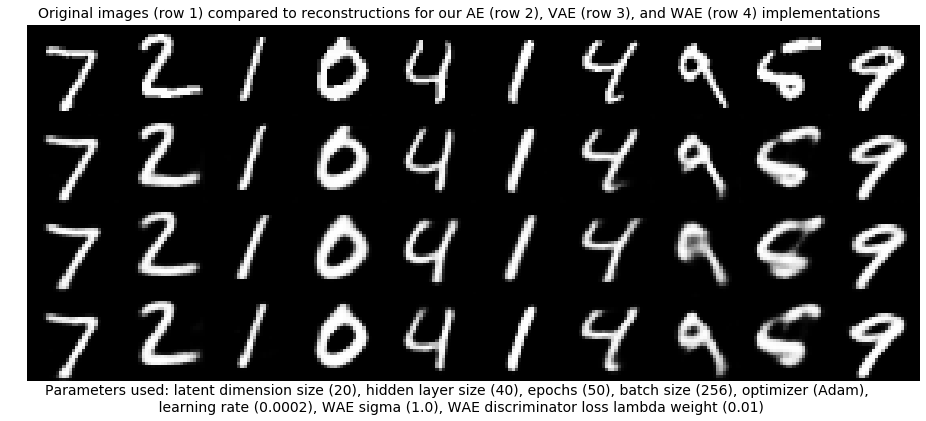

In [55]:
plot_rows(images, save=True, padding=False, 
          filename="./images/reconstructions_MNIST.png")

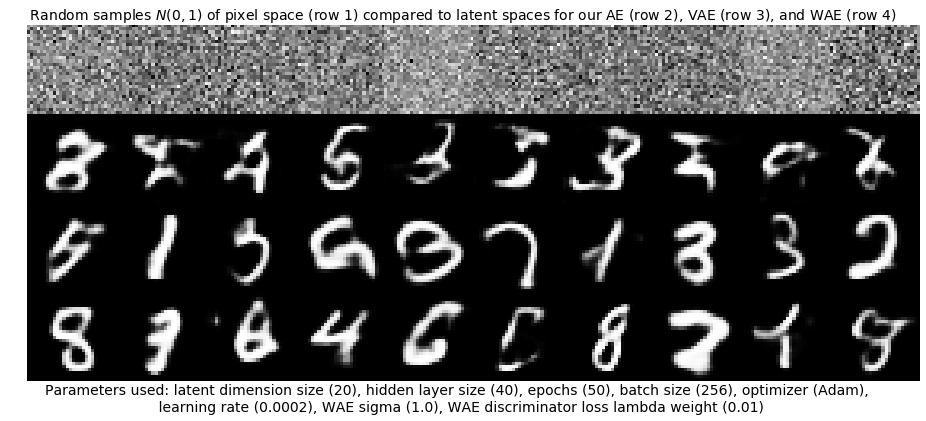

In [56]:
plot_random(images, save=True, padding=False,
            filename="./images/random_MNIST.png")

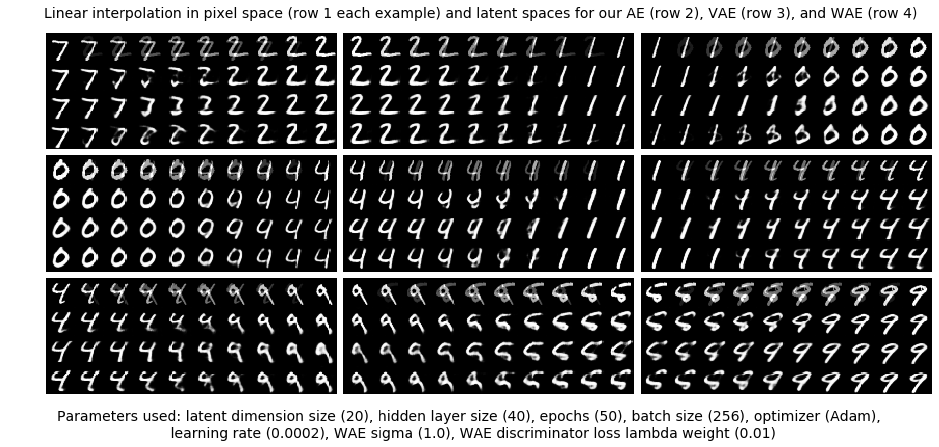

CPU times: user 1min 5s, sys: 1.57 s, total: 1min 6s
Wall time: 55.5 s


In [57]:
%%time 

plot_grid_interpolation(images, save=True, padding=False,
                        temp_path="./images/interpolations_MNIST/", 
                        filename="./images/grid_interpolations_MNIST.png")